In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
from implementations import *
from plots import *
from cleaner import *

%load_ext autoreload
%autoreload 2

## 1. Exploratory analysis

Here we explain how and why we cleaned the data. Moreover, we pre-compute some values that will be either hardcoded or stored to file so that the cleaning prosess will be the same both for the train and for the test set.

### Load and merge training and test data

In [2]:
data_path = "../../dataset/train.csv"
y_loaded, data_loaded, _ = load_csv_data(data_path)
data_loaded.shape

(250000, 30)

In [3]:
data_path = "../../dataset/test.csv"
_, data_test_loaded, _ = load_csv_data(data_path)
data_test_loaded.shape

(568238, 30)

In [4]:
data_merged = np.concatenate((data_loaded,data_test_loaded), axis=0)
data_merged.shape

(818238, 30)

### Plot ditributions 
The first step to understand the data is to plot it. Here we plot (1) every value of every feature, (2) the histogram and (3) the distribution for each feature. 

#### Plot all values
Plotting all the values can be usefull to determine if and how many outliers there are and also identify the categorical features. In these plots we consider both the training and the test set.

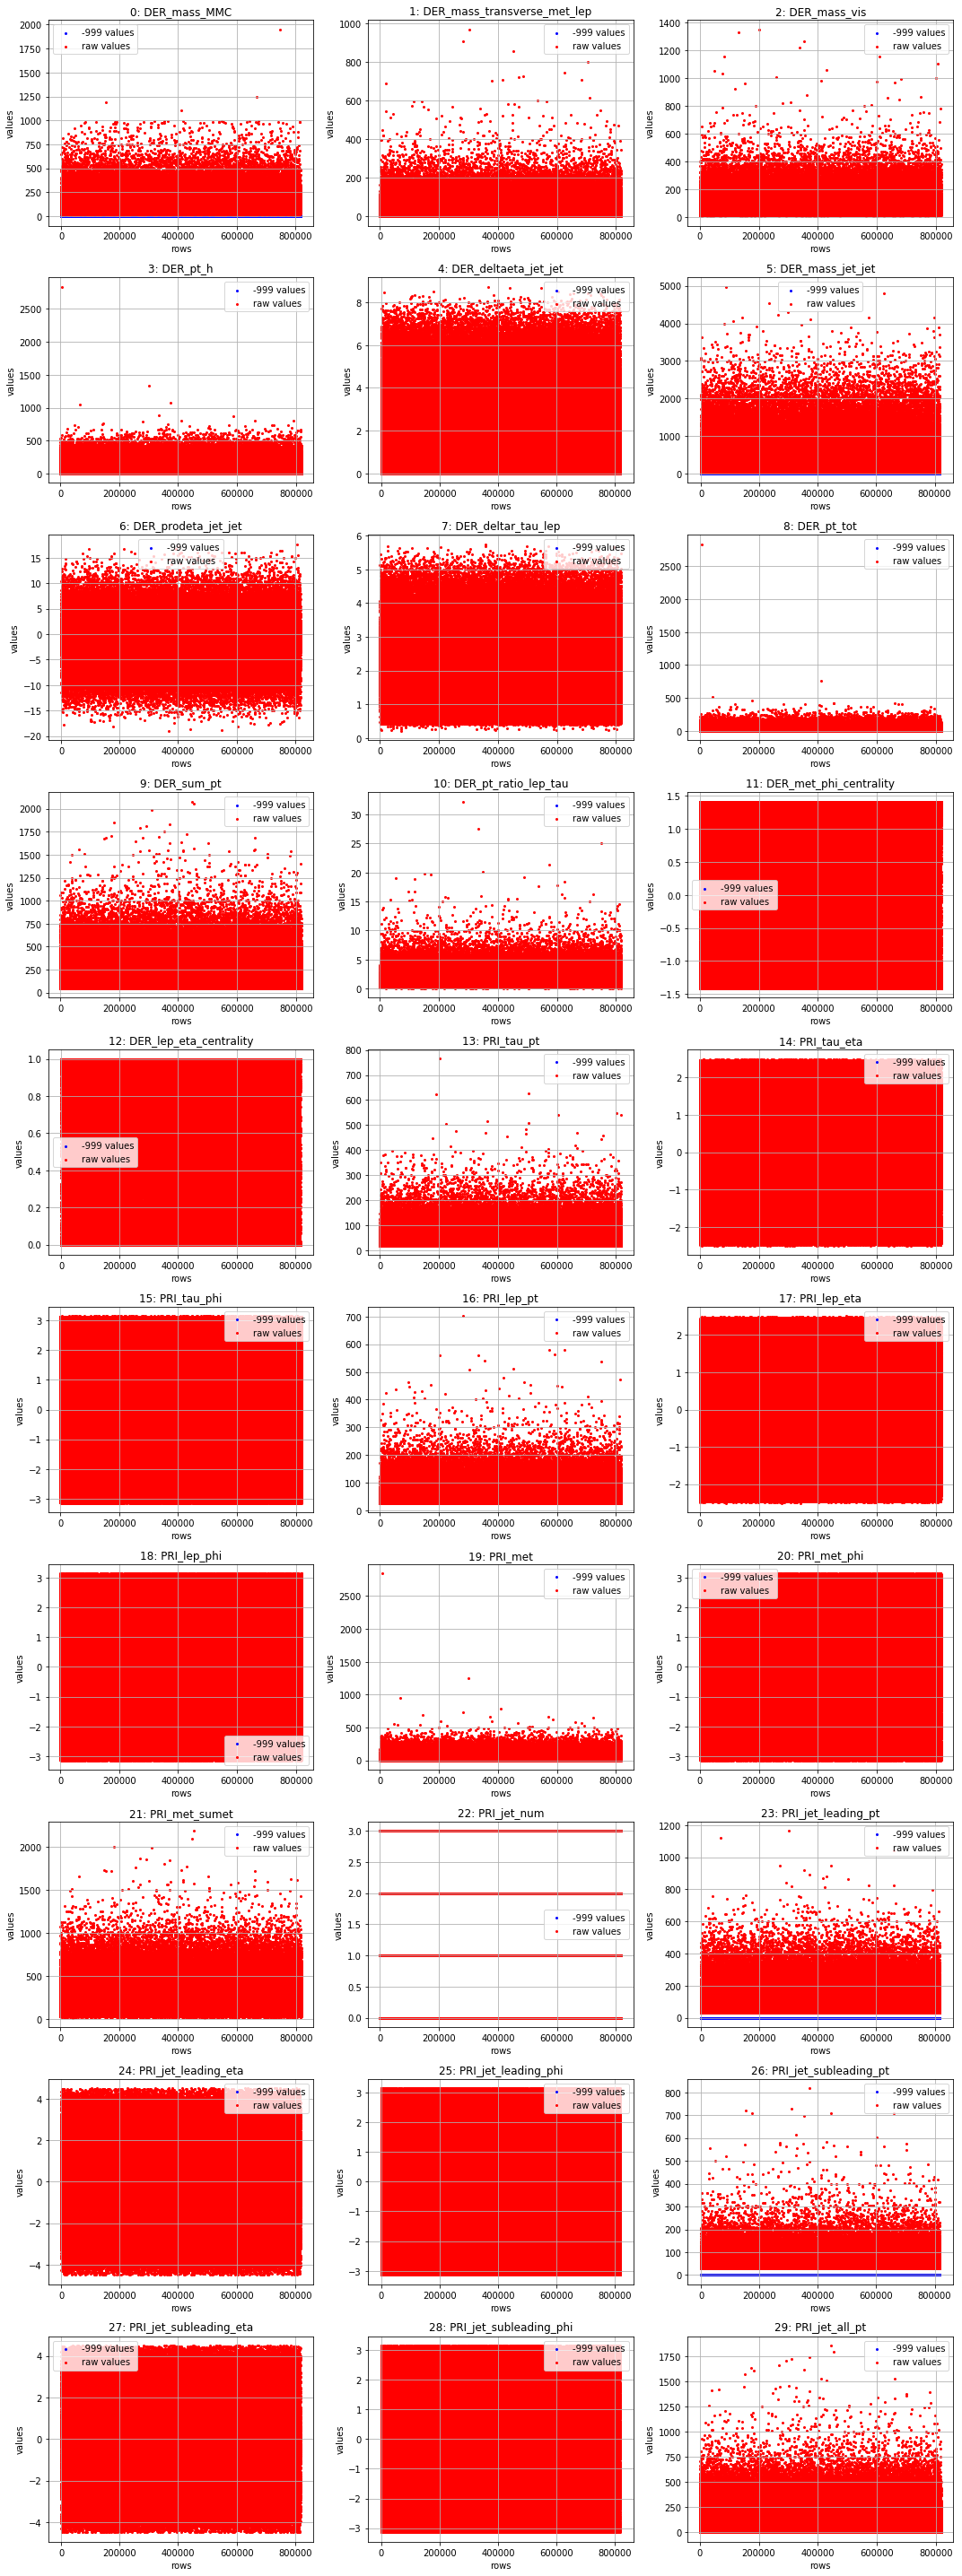

In [5]:
plot_features(data_merged, col_labels = column_labels(), title="values")

We observe that there are very few outliers and that, given the amount of data, they shouldn't affect much the computation of the mean and of the standard deviation. Moreover, the only categorical feature is PRI_jet_num (column 22), we will study further what this feature represents and if/how it affect other features.

#### Plot the histograms and the distributions
In the graps below we plotted the histogram (left column) and the distribution (rigth column) of each feature depending on the output. In this way, we can compare the distribution of each feature and check by eye if it changes depending on the output y. In these graphs we can consider only the training data since we need the value of the output y to split the input data.

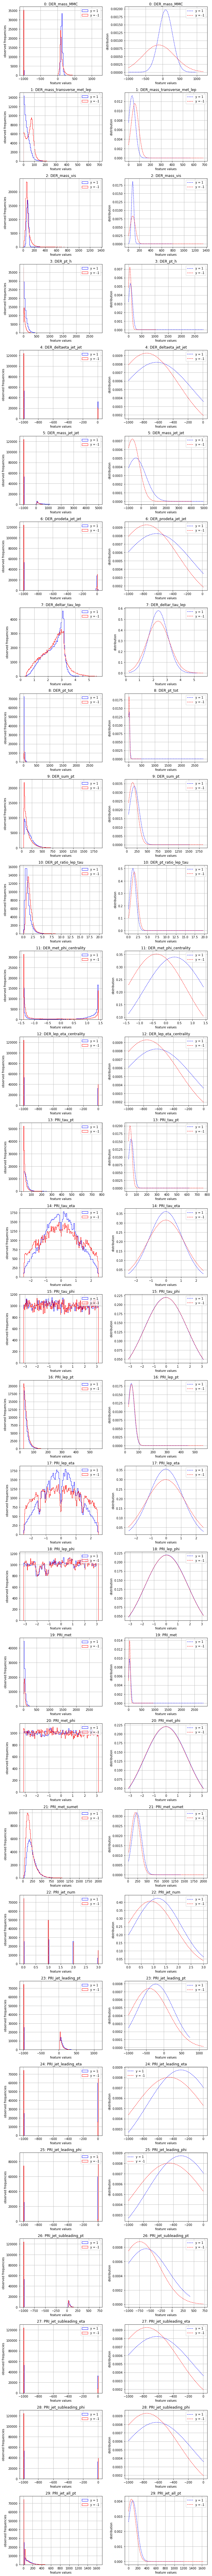

In [6]:
plot_distributions(data_loaded, y_loaded, col_labels = column_labels(), title = "", normed=False)

We observe that there are the distribution of the four features PRI_tau_phi, PRI_lep_pt, PRI_lep_phi, PRI_met_phi (respectively columns 15, 16, 18, 20) seems to be independent from the output y. We will try to drop these columns and verify how it affects out model. Finally, we notice the precence of lot of -999 numbers.

### Our approach: split data depending on the feature PRI_jet_num

#### Why divide data depending on jet numbers and which columns can we drop?

After reading information on the dataset we learned that the jet number affects the presence of -999 (invalid) values in other features. Therefore, we splitted our input data in four sets depending on the jet number and verified it.

Divide the data depending on the jet number (column 22) that is a categorical number in {0, 1, 2, 3}

In [7]:
all_data = data_merged.copy()
jets_0 = all_data[all_data[:, 22]==0, :]
jets_1 = all_data[all_data[:, 22]==1, :]
jets_2 = all_data[all_data[:, 22]==2, :]
jets_3 = all_data[all_data[:, 22]==3, :]
jets_0.shape, jets_1.shape, jets_2.shape, jets_3.shape 

((327371, 30), (252882, 30), (165027, 30), (72958, 30))

Where are the -999 values?
- jet = 0: columns [4, 5, 6, 12, 23, 24, 25, 26, 27, 28] contain only -999 values, 26.1% of entries in the first column have -999
- jet = 1: columns [4, 5, 6, 12, 26, 27, 28] contain only -999 values, 7.6% of entries in the first column have -999
- jet = 2: 3% of entries in the first column have -999
- jet = 3: 1.4% of entries in the first column have -999

We decided to drop in every set the columns that store only -999 values (since they do not keep any information). However, the first feature (DER_mass_MMC) is the only one that contains -999 values in all the 4 sets without filling completely the column. We tried to impute this invalid value with mean, std, median and also simply subtituted it with 0s (after standardization). After several trials we understood that this invalid value didn't "fit" in the column and therefore it could need a different weight from the other values of the same column. Therefore, we opted for the more versatile solution: add a boolean column to indicate the position of the -999 values and delete them from first column. By "delete" we mean: substitute them with 0s after standardization, where during standardization we ignored those invalid values so that they didn't affect mean and standard deviation.

In [ ]:
for jet, cur_set in enumerate([jets_0, jets_1, jets_2, jets_3]):
    print("Features in the dataset with jet=", jet, "contains this many values != -999")
    for col in range(30):
        print(col, np.sum(cur_set[:, col] != -999))
    print()

Where are the 0 values?
- jet = 0: column 29 contains only 0s and, obviously, column 22 too since it stores the jet num.
- jet = 1: spread
- jet = 2: spread
- jet = 3: spread

In [ ]:
for jet, cur_set in enumerate([jets_0, jets_1, jets_2, jets_3]):
    print("Features in the dataset with jet=", jet, "contains this many values != 0")
    for col in range(30):
        print(col, np.sum(cur_set[:, col] != 0))
    print()

After this first analysis we surely want to drop the following columns since they do not contain any useful information:
- jet = 0: [4, 5, 6, 12, 22, 23, 24, 25, 26, 27, 28, 29]
- jet = 1: [4, 5, 6, 12, 22, 26, 27, 28] 
- jet = 2: [22]
- jet = 3: [22]

The column 22 is dropped in every obtained dataset since it stores, within each dataset, a constant representing the jet number. 

### Compute the correlation between the features 

After deciding to split the data and train the sets independenlty we study if each dataset could be simplified further. In this step we verify if there are some highly correlated features within each one of the four datasets. If so, it is worth trying to drop all but 1 columns in a set of correlated features and check how the model is influenced.

- Split the data and drop the useless columns as explained in the previous point.

In [10]:
# split data
datasets, _ = split_input_data(data_merged.copy()) # split and drop
datasets[0].shape, datasets[1].shape, datasets[2].shape, datasets[3].shape

Jet 0 useless columns dropped: [4, 5, 6, 12, 22, 23, 24, 25, 26, 27, 28, 29]
Jet 1 useless columns dropped: [4, 5, 6, 12, 22, 26, 27, 28]
Jet 2 useless columns dropped: [22]
Jet 3 useless columns dropped: [22]


((327371, 18), (252882, 22), (165027, 29), (72958, 29))

- Compute the correlation matrix for each one of the 4 datasets.

In [11]:
# compute correlation matrices
corr_matrices = [None]*4
for jet in range(4):
    # don't consider the first column since it contains nan values (we will simply keep that column)
    corr_matrices[jet] = np.corrcoef(datasets[jet][:, 1:].T) 
    
    # to keep the same indexing of the columns just add one row above and one column at the left
    corr_matrices[jet] = np.column_stack((np.zeros((corr_matrices[jet].shape[0], 1)), corr_matrices[jet]))   
    corr_matrices[jet] = np.row_stack((np.zeros((1, corr_matrices[jet].shape[1])), corr_matrices[jet]))

corr_matrices[0].shape, corr_matrices[1].shape, corr_matrices[2].shape, corr_matrices[3].shape

((18, 18), (22, 22), (29, 29), (29, 29))

- For some correlation values check which are the features that have an higher |correlation|.

In [12]:
# compute the mapping of |correlations| > min_corr 
min_correlations = [0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95]
corr_mappings = {} # mapping: jet -> minimum correlation -> features -> list of correlated features
for jet in range(4): # for each dataset build the correlation mapping
    corr_mappings[jet] = {}
    for min_corr in min_correlations: #for each min correlation considered
        corr_mappings[jet][min_corr] = {}
        corr_matrix_bool = np.abs(corr_matrices[jet]) > min_corr 
        nfeature = corr_matrix_bool.shape[0]
        # i is surely correlated to itself, drop that (useless) information
        for i in range(nfeature):
            corr_matrix_bool[i][i] = False

        # compute the mapping of correlations
        for i in range(nfeature):
            c = np.where(corr_matrix_bool[i])[0].tolist()
            if len(c) > 0: # if it is not correlated to any other column then ignore it
                corr_mappings[jet][min_corr][i] = c
    

- Finally, compute the columns that could be dropped for each considered minimum correlation.

In [13]:
def empty(map_):
    for k in map_:
        if len(map_[k]) > 0:
            return False
    return True

# jet -> minimum correlation -> features -> list of correlated features

tobe_deleted = {} # mapping: jet -> minimum correlation -> list of columns that can be dropped
for jet in range(4): # for each dataset build the correlation mapping
    tobe_deleted[jet] = {}
    for min_corr, corr in corr_mappings[jet].items():
        tobe_deleted[jet][min_corr] = []
        # fetch all the columns that can be deleted and put them in tobe_deleted
        while not empty(corr): 
            longer_key = -1 
            longer_length = 0

            # look for the longer list
            for key in corr:
                curr_length = len(corr[key])
                if curr_length > longer_length:
                    longer_length = curr_length
                    longer_key = key

            tobe_deleted[jet][min_corr].append(corr[longer_key])
            # delete all the columns that are correlated to column longer_key
            # i.e. all the column whose index is in  corr[longer_key]
            for corr_colum in corr[longer_key]:
                corr[corr_colum] = []

            # since those columns have been dropped they must be removed from all the other lists
            for key in corr: 
                if key != longer_key:
                    corr[key] = list(set(corr[key]) - set(corr[longer_key]))
            corr[longer_key] = []

        tobe_deleted[jet][min_corr] = [val for sublist in tobe_deleted[jet][min_corr] for val in sublist]
        tobe_deleted[jet][min_corr].sort()
tobe_deleted

{0: {0.7: [5, 9, 12, 15],
  0.75: [5, 9, 12],
  0.8: [5],
  0.85: [5],
  0.9: [5],
  0.95: [5]},
 1: {0.7: [6, 12, 17, 18, 21],
  0.75: [3, 17, 18, 21],
  0.8: [6, 18, 21],
  0.85: [6, 18, 21],
  0.9: [3, 6, 21],
  0.95: [21]},
 2: {0.7: [5, 6, 9, 16, 19, 21, 22, 28],
  0.75: [3, 5, 6, 21, 22, 28],
  0.8: [5, 6, 21, 22, 28],
  0.85: [6, 21, 22, 28],
  0.9: [22, 28],
  0.95: [28]},
 3: {0.7: [5, 6, 16, 19, 21, 22, 25, 28],
  0.75: [5, 6, 16, 21, 22, 25, 28],
  0.8: [9, 21, 22, 25],
  0.85: [21, 22, 28],
  0.9: [21, 28],
  0.95: [28]}}

The found maps show, for evey dataset and for every chosen minimum correlation a list of features that can be dropped, e.g. tobe_deleted[2][0.85] contains a list of features in the jet=2 dataset which have a |correlation| > 0.85 with at least one of the feature that is kept in the dataset (and therefore can be dropped).

### Compute mean and std

We must use the same standardisation process both for preparing the training set and the test set. Therefore, we precompute the mean and the standard deviation that will be used for during standardization. Since the -999 values will be dropped from the first column we remove them before computing the mean and the std.

In [14]:
data = data_merged.copy()
data[data==-999] = np.nan
means = np.nanmean(data, axis=0)
std_devs = np.nanstd(data, axis=0)
means, std_devs

(array([  1.21867697e+02,   4.92527141e+01,   8.11405610e+01,
          5.78495242e+01,   2.40462573e+00,   3.72181050e+02,
         -8.28740433e-01,   2.37387138e+00,   1.89696172e+01,
          1.58596159e+02,   1.43877554e+00,  -1.27277218e-01,
          4.58479934e-01,   3.86981522e+01,  -1.16628927e-02,
         -1.31581349e-02,   4.66924138e+01,  -1.90794708e-02,
          4.94604088e-02,   4.16545265e+01,  -8.63427634e-03,
          2.09908730e+02,   9.79922712e-01,   8.49042850e+01,
         -1.24800608e-03,  -1.88564316e-02,   5.78102860e+01,
         -6.66904637e-03,  -1.04697019e-02,   7.32055938e+01]),
 array([  5.69424463e+01,   3.53785872e+01,   4.05826830e+01,
          6.34118997e+01,   1.74254260e+00,   3.98234556e+02,
          3.58376128e+00,   7.80874852e-01,   2.19184774e+01,
          1.16089739e+02,   8.45108795e-01,   1.19423410e+00,
          3.98145140e-01,   2.24290027e+01,   1.21351057e+00,
          1.81608204e+00,   2.21423233e+01,   1.26424960e+00,
      

We hardcode these values for the standardization process.

### Percentiles computation

A techinque we tried and that allowed to increase the ratio of correctly predicted ouputs is what we called dimension expansion. We divide each feature in N feature using the percentiles, e.g. if N=2 we take the median and split a column in 2 new columns, one with all the entries below the median and one with all the entries above the median. This allows to split the dimension of the input in deifferent intervals in which the regression can be trained independently (immagine if you have to fit an exponential with a 1-degree polynomial, you split the input in 2 and use two 1-degree polynomials instead of 1).

- First, separate the data in the four datasets.

In [15]:
# clean the merged dataset
x_all, _ = clean_input_data(data_merged.copy())

Capping the outliers
Jet 0 useless columns dropped: [4, 5, 6, 12, 22, 23, 24, 25, 26, 27, 28, 29]
Jet 1 useless columns dropped: [4, 5, 6, 12, 22, 26, 27, 28]
Jet 2 useless columns dropped: [22]
Jet 3 useless columns dropped: [22]


- Then, for each dataset, for each feature, computer the percentiles that will be used to separate that feature.

In [16]:
# [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
# gerarchical maps: jet -> column -> percentile
percentiles = {} 
for jet in x_all:
    percentiles[jet] = {} 
    
    scan_perc = list(range(0, 101, 5))
    #col_perc = np.zeros((len(scan_perc), data_merged.shape[1]))
    for col in range(x_all[jet].shape[1]): # scan columns
        percentiles[jet][col] = {}
        for p in scan_perc:
             percentiles[jet][col][p] = np.nanpercentile(x_all[jet][:, col], p)

- Finally, store to file the computed percentiles so that they will be used both on the train and on the test dataset.

In [17]:
# store the computed percentiles 
file_path = "percentiles.json"
json.dump(percentiles, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

## 2. Train the model using logistic regression

#### a. Load the train dataset

In [18]:
data_path = "../../dataset/train.csv"
y_loaded, x_loaded, ids_te = load_csv_data(data_path, sub_sample=False)
y_loaded = y_loaded.reshape((-1, 1))
y_loaded.shape, x_loaded.shape

((250000, 1), (250000, 30))

#### b. Clean the dataset (also choosing parameters for the cleaning)

In [19]:
corr = 1
dimension_expansion = 5
bool_col = True
xs, ys = clean_input_data(x_loaded.copy(), y_loaded.copy(), corr=corr, 
                                dimension_expansion=dimension_expansion, bool_col=bool_col)
for i in range(len(ys)):
    ys[i][ys[i]== -1] = 0
xs[0].shape, xs[1].shape, xs[2].shape, xs[3].shape

Capping the outliers
Jet 0 useless columns dropped: [4, 5, 6, 12, 22, 23, 24, 25, 26, 27, 28, 29]
Jet 1 useless columns dropped: [4, 5, 6, 12, 22, 26, 27, 28]
Jet 2 useless columns dropped: [22]
Jet 3 useless columns dropped: [22]


((99913, 91), (77544, 111), (50379, 146), (22164, 146))

We also tried to concatenate to our datasets their logarithm and wich led to a noticeable improvement. After concatenating the log we have to standardize it (we will use the same means and stds to standardize the test set).

In [20]:
xs, mean_log, std_log = concatenate_log(xs.copy())
xs[0].shape, xs[1].shape, xs[2].shape, xs[3].shape

((99913, 182), (77544, 222), (50379, 292), (22164, 292))

#### c. Build the polynomial on each one of the 4 datasets.

In [21]:
# choose the degree and build a polynomial out of each onw of the 4 datasets
degree = 2
txs = [None]*4
for jet in range(4):
    txs[jet] = build_poly(xs[jet], degree)
    print(txs[jet].shape, ys[jet].shape)

(99913, 365) (99913, 1)
(77544, 445) (77544, 1)
(50379, 585) (50379, 1)
(22164, 585) (22164, 1)


#### d. Set the initial gamma 
We noticed that the higher the degree the lower was the gamma needed to have a stable gradient descent leading to a higher coverging time. Therefore, instead of using a scalar gamma we used an array of gammas and tuned them independently. In particular, this array of gammas is as long as the gradient of L(w) and allows for choosing a different step size for different parts of the gradient therefore achieving more versatility.
Another solution would have been to normalize after building the polynomial (still normalizing the test polynomial and the train polynomial with the same constants), but we achieved a higher converging time with the latter therefore we opted for the array of gammas.

In [22]:
# gamma_constants is an array of tuned constants we use to build our vectorial tgamma 
gamma_constants = [1e-5, 1e-6, 1e-7, 1e-10, 1e-12, 1e-15] # only up to the 6th degree since we didn't notices any improvements
gammas = [None]*4
print("The gamma should be as long as the gradient vector (whose length is equal to the number of columns in tx)")
for jet in range(4):
    ncolumns = xs[jet].shape[1] # I build the gamma depending on the columns of the dataset 'jet' and on the degree 
    gammas[jet] = np.concatenate([[gamma_constants[0]]] + [ncolumns*[g] for g in gamma_constants[:degree]])\
        .reshape((-1,1))
    print(txs[jet].shape, gammas[jet].shape)

The gamma should be as long as the gradient vector (whose length is equal to the number of columns in tx)
(99913, 365) (365, 1)
(77544, 445) (445, 1)
(50379, 585) (585, 1)
(22164, 585) (585, 1)


#### e. Logistic regression using gradient descent

In [23]:
def logistic_regression_on_jet(jet):
    y = ys[jet]
    tx = txs[jet]
    
    initial_w = weigths[jet] #np.zeros((tx.shape[1], 1)) #
    max_iters = 100
    return logistic_regression(y, tx, initial_w, max_iters, gammas[jet])

In [39]:
# we will have four weigth vectors, one per dataset
weigths = [np.zeros((tx.shape[1])) for tx in txs]*4

- First dataset (jet = 0)

Gradient Descent(0/99): loss=64268.2203846304, prediction ratio=0.7449280874360694
Gradient Descent(10/99): loss=37682.171571067825, prediction ratio=0.8355469258254682
Gradient Descent(20/99): loss=36791.75842065291, prediction ratio=0.8393202085814658
Gradient Descent(30/99): loss=36345.05152455761, prediction ratio=0.840931610501136
Gradient Descent(40/99): loss=36052.823555740004, prediction ratio=0.841932481258695
Gradient Descent(50/99): loss=35844.15651465327, prediction ratio=0.8429033258935273
Gradient Descent(60/99): loss=35687.55530027884, prediction ratio=0.8436039354238187
Gradient Descent(70/99): loss=35565.982379248286, prediction ratio=0.8438441444056329
Gradient Descent(80/99): loss=35469.06469310366, prediction ratio=0.8445947974738022
Gradient Descent(90/99): loss=35390.03617707664, prediction ratio=0.8448149890404653
Gradient Descent(99/99): loss=35330.373755106695, prediction ratio=0.8453654679571228


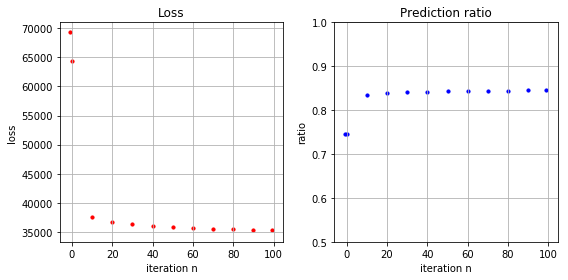

Final prediction ratio:  0.845365467957


In [40]:
jet = 0
loss, weigths[jet] = logistic_regression_on_jet(jet)
print("Final prediction ratio: ", compute_loss(ys[jet], txs[jet], weigths[jet], costfunc=CostFunction.SUCCESS_RATIO))

- Second dataset (jet = 1)

Gradient Descent(0/99): loss=48172.04264789931, prediction ratio=0.6515784586815228
Gradient Descent(10/99): loss=35936.21267896899, prediction ratio=0.7833617043227071
Gradient Descent(20/99): loss=34430.031070336656, prediction ratio=0.7967089652326421
Gradient Descent(30/99): loss=33931.284344103544, prediction ratio=0.8003971938512329
Gradient Descent(40/99): loss=33645.0800415921, prediction ratio=0.8023960590116579
Gradient Descent(50/99): loss=33447.06945541494, prediction ratio=0.8035051067780873
Gradient Descent(60/99): loss=33299.892750861574, prediction ratio=0.8041627978953885
Gradient Descent(70/99): loss=33186.543616237585, prediction ratio=0.8048720726297328
Gradient Descent(80/99): loss=33096.9281369525, prediction ratio=0.8056716186939028
Gradient Descent(90/99): loss=33024.44737562033, prediction ratio=0.8059811203961622
Gradient Descent(99/99): loss=32970.12673025999, prediction ratio=0.8062777261941607


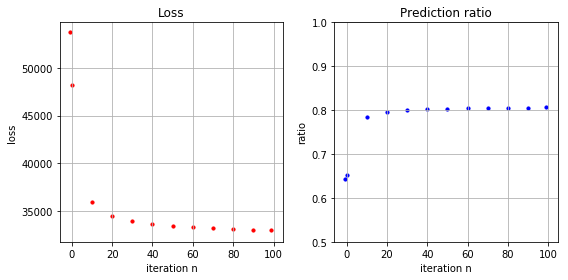

Final prediction ratio:  0.806277726194


In [41]:
jet = 1
loss, weigths[jet]  = logistic_regression_on_jet(jet)
print("Final prediction ratio: ", compute_loss(ys[jet], txs[jet], weigths[jet], costfunc=CostFunction.SUCCESS_RATIO))

- Third dataset (jet = 2)

Gradient Descent(0/99): loss=26246.698346836893, prediction ratio=0.760634391313841
Gradient Descent(10/99): loss=22209.423844175166, prediction ratio=0.7975545366124774
Gradient Descent(20/99): loss=20555.094758304047, prediction ratio=0.8176422715814129
Gradient Descent(30/99): loss=20094.623454413813, prediction ratio=0.8234978860239386
Gradient Descent(40/99): loss=19837.69138355963, prediction ratio=0.8253438932888704
Gradient Descent(50/99): loss=19657.05324355558, prediction ratio=0.8266341134202744
Gradient Descent(60/99): loss=19516.85520933615, prediction ratio=0.827884634470712
Gradient Descent(70/99): loss=19402.375043493, prediction ratio=0.8291550050616329
Gradient Descent(80/99): loss=19306.146194012952, prediction ratio=0.8299489866809583
Gradient Descent(90/99): loss=19223.82734557789, prediction ratio=0.8300879334643403
Gradient Descent(99/99): loss=19159.389757078305, prediction ratio=0.8312987554338117


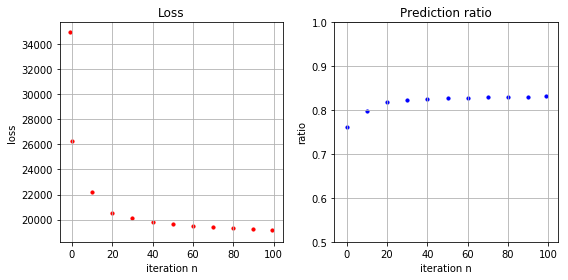

Final prediction ratio:  0.831298755434


In [42]:
jet = 2
loss, weigths[jet] = logistic_regression_on_jet(jet)
print("Final prediction ratio: ", compute_loss(ys[jet], txs[jet], weigths[jet], costfunc=CostFunction.SUCCESS_RATIO))

- Fourth dataset (jet = 3)

Gradient Descent(0/99): loss=13784.451906937438, prediction ratio=0.6963093304457679
Gradient Descent(10/99): loss=9971.860731387997, prediction ratio=0.8003519220357336
Gradient Descent(20/99): loss=9424.431775266487, prediction ratio=0.8164591229020033
Gradient Descent(30/99): loss=9195.300837631137, prediction ratio=0.8224598447933587
Gradient Descent(40/99): loss=9061.849636258317, prediction ratio=0.8261144197798231
Gradient Descent(50/99): loss=8971.26169318269, prediction ratio=0.8285056848944234
Gradient Descent(60/99): loss=8903.965391763246, prediction ratio=0.8296787583468688
Gradient Descent(70/99): loss=8850.70359844926, prediction ratio=0.8307615953798954
Gradient Descent(80/99): loss=8806.774533200569, prediction ratio=0.831348132106118
Gradient Descent(90/99): loss=8769.48357305158, prediction ratio=0.8323407327197256
Gradient Descent(99/99): loss=8740.210661452293, prediction ratio=0.8326565601876917


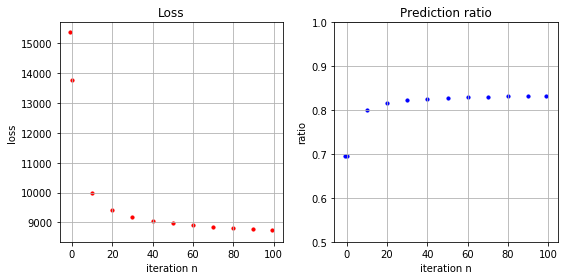

Final prediction ratio:  0.832656560188


In [43]:
jet = 3
loss, weigths[jet] = logistic_regression_on_jet(jet)
print("Final prediction ratio: ", compute_loss(ys[jet], txs[jet], weigths[jet], costfunc=CostFunction.SUCCESS_RATIO))

## 3. Create submit file

##### a. Load test data

In [29]:
data_path = "../../dataset/test.csv"
y_te_loaded, x_te_loaded, ids_te_loaded = load_csv_data(data_path, sub_sample=False)
y_te_loaded.shape, x_te_loaded.shape

((568238,), (568238, 30))

#### b. Clean
We clean the test dataset in the exact same way we cleaned the train dataset.

In [30]:
x_te, ids_te = clean_input_data(x_te_loaded.copy(), ids_te_loaded.copy(), corr=corr, 
                                dimension_expansion=dimension_expansion, bool_col=bool_col)
x_te[0].shape, x_te[1].shape, x_te[2].shape, x_te[3].shape

Capping the outliers
Jet 0 useless columns dropped: [4, 5, 6, 12, 22, 23, 24, 25, 26, 27, 28, 29]
Jet 1 useless columns dropped: [4, 5, 6, 12, 22, 26, 27, 28]
Jet 2 useless columns dropped: [22]
Jet 3 useless columns dropped: [22]


((227458, 91), (175338, 111), (114648, 146), (50794, 146))

As with the training set, we concatenate to each dataset its logarithm and we use

In [31]:
x_te, _, _ = concatenate_log(x_te.copy(), mean_log=mean_log, std_log=std_log)

#### c. Build the polynomial
We build the polynomials (one per dataset) with the same degree we used with the train the data.

In [32]:
tx_te = []
for jet in range(4):
    tx_te.append(build_poly(x_te[jet], degree))
tx_te[0].shape, tx_te[1].shape, tx_te[2].shape, tx_te[3].shape

((227458, 365), (175338, 445), (114648, 585), (50794, 585))

####  d. Predict 

In [33]:
y_te_pred = []
for jet in range(4):
    y_te_pred.append(predict_labels(weigths[jet], tx_te[jet]))
y_te_pred[0].shape, y_te_pred[1].shape, y_te_pred[2].shape, y_te_pred[3].shape

((227458, 1), (175338, 1), (114648, 1), (50794, 1))

In [34]:
# concatenate all the results
for jet in range(4):
    ids_te[jet] = ids_te[jet].reshape((-1, 1))
y_pred = np.row_stack([y_te_pred[0], y_te_pred[1], y_te_pred[2], y_te_pred[3]])
ids = np.row_stack([ids_te[0], ids_te[1], ids_te[2], ids_te[3]])
y_pred.shape, ids.shape

((568238, 1), (568238, 1))

In [35]:
# check it makes sense
(y_pred==-1).sum(), (y_pred==1).sum()

(392034, 176204)

#### e. Store predictions

In [36]:
# store the predictions
sub_file_name = "predictions"
create_csv_submission(ids, y_pred, sub_file_name)

## Store/load weights

### Store

In [ ]:
for jet in range(4):
    file_path = "../weigths/" + "w" + str(jet)
    json.dump(weigths[jet].tolist(), codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

### Load

In [ ]:
weigths = []
for weigth_name in ["w0", "w1", "w2", "w3"]:
    file_path = "weigths/with_perc3/"+weigth_name
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    weigths.append(np.array(json.loads(obj_text)))
weigths[0].shape, weigths[1].shape, weigths[2].shape, weigths[3].shape